
# Setup


## Imports


In [1]:
import functools
import pathlib
from pprint import pprint
import sys
import yaml
from yaml import YAMLObject
from typing import *

import attr
import humanize
from matplotlib import pyplot as plt, cm
import numpy as np
import pandas as pd
from pymicro.file import file_utils

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import losses

In [2]:
print(f"tensorflow version: {tf.__version__}")

tensorflow version: 2.2.0


In [5]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
%autoreload 2
from tomo2seg import modular_unet
from tomo2seg.volume_img_segm import VolumeImgSegmSequence
from tomo2seg.logger import logger
from tomo2seg import data
from tomo2seg.data import VolumePaths, ModelPaths

## GPUs


In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [8]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU')]

In [9]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:GPU:1', device_type='GPU'),
 LogicalDevice(name='/device:XLA_GPU:0', device_type='XLA_GPU'),
 LogicalDevice(name='/device:XLA_GPU:1', device_type='XLA_GPU')]

In [10]:
# set xla auto-clustering optimization
# see: https://www.tensorflow.org/xla#auto-clustering
tf.config.optimizer.set_jit(True)
tf.config.optimizer.get_jit()

True

In [11]:
# set xla auto-clustering optimization
# see: https://www.tensorflow.org/xla#auto-clustering
tf.config.optimizer.set_jit(True)
tf.config.optimizer.get_jit()

True

In [12]:
# get a distribution strategy to use both gpus
# see https://www.tensorflow.org/guide/distributed_training
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


# Data

## File paths


In [28]:
volume_name = data.VOLUME_PRECIPITATES_DRYRUN
volume_paths = data.volume_precipitates_dryrun

logger.info("Working with volume `%s`: %s", volume_name, volume_paths)

[2020-10-14::14:41:35.931] tomo2seg :: INFO :: {<ipython-input-28-1b32abc8a087>:<module>:004}
Working with volume `PA66GF30_trans3_x__0_pag`: VolumePaths(volume_name='PA66GF30_trans3_x__0_pag')


In [29]:
class labels:
  matrix = 0
  fiber = 1
  hole = 2

labels_list = [0, 1, 2]

dimensions = (500, 500, 500)
dtype = "uint8"  # todo remove the cast inside the generator?

# prefill the function `HST_read`
hst_read = functools.partial(
    file_utils.HST_read,
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=dtype,
    dims=dimensions,
    verbose=True,
)

## Load volumes


In [32]:
train_volume = hst_read(str(volume_paths.train_data_path))
train_labels = hst_read(str(volume_paths.train_labels_path))

val_volume = hst_read(str(volume_paths.val_data_path))
val_labels = hst_read(str(volume_paths.val_labels_path))

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0


## Plot slices with labels


In [33]:
def tightsubplots(n, m, w, h):
  fig, axs = plt.subplots(n, m, figsize=(w, h), sharex=True, sharey=True)
  fig.set_tight_layout(True)
  return fig, axs

(-0.5, 499.5, 499.5, -0.5)

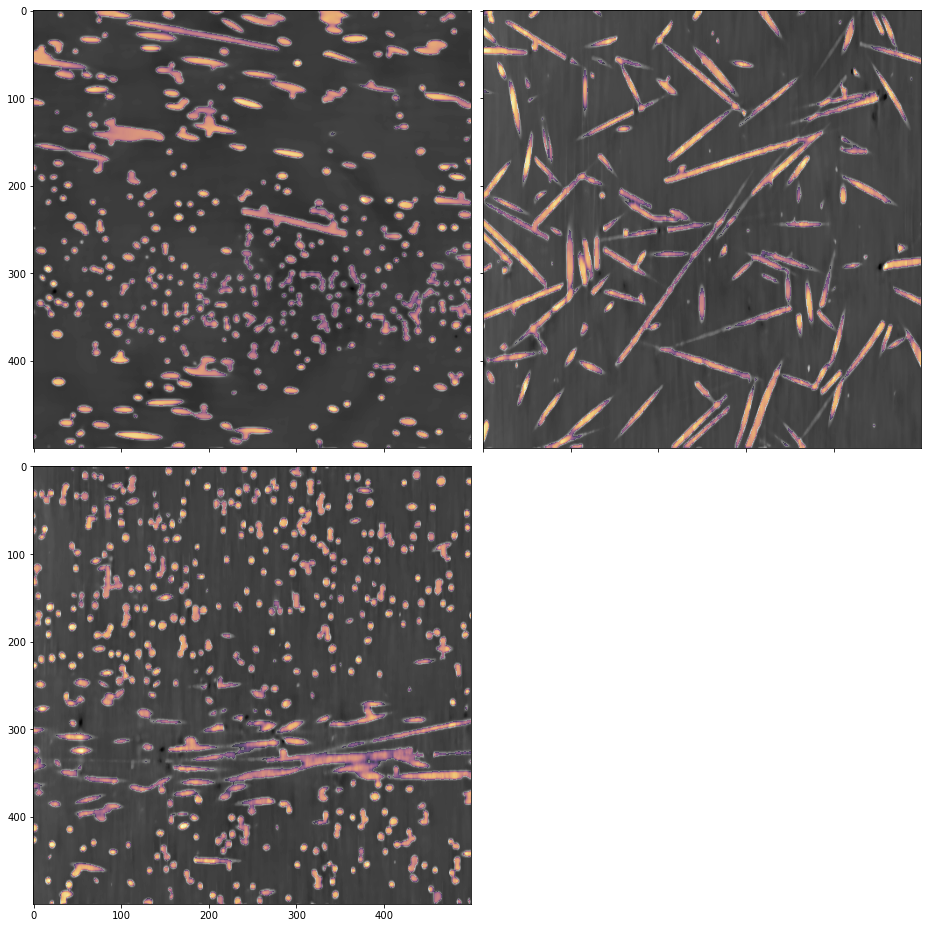

In [34]:
fig, axs = tightsubplots(2, 2, 13, 13)

volume = train_volume
mask = (~ (train_labels == labels.fiber)).astype(int)

axs[0, 0].imshow(volume[:, :, 250], cmap=cm.gray, interpolation=None)
axs[0, 1].imshow(volume[250, :, :], cmap=cm.gray)
axs[1, 0].imshow(volume[:, 250, :], cmap=cm.gray)

volume_masked = np.ma.masked_where(mask, volume)
axs[0, 0].imshow(volume_masked[:, :, 250], cmap=cm.inferno, interpolation=None, alpha=0.5)
axs[0, 1].imshow(volume_masked[250, :, :], cmap=cm.inferno, interpolation=None, alpha=0.5)
axs[1, 0].imshow(volume_masked[:, 250, :], cmap=cm.inferno, interpolation=None, alpha=0.5)

axs[1, 1].axis(False)

## Data Sequences

In [36]:
batch_size = 32
crop_size = 224  # multiple of 16 (requirement of a 4-level u-net)
n_geometric_augmentations = 3  # all
slice_axes = (0, 1, 2,)

train_generator = VolumeImgSegmSequence(
    source_volume=train_volume, 
    label_volume=train_labels,
    labels=labels_list, 
    axes=slice_axes, 
    batch_size=batch_size,
    shuffle=True,
    normalization_const=255,
    n_geometric_augmentations=n_geometric_augmentations,
    random_state=42,
    crop_size=crop_size,
)

val_generator = VolumeImgSegmSequence(
    source_volume=val_volume, 
    label_volume=val_labels,
    labels=labels_list, 
    axes=(2,), 
    batch_size=10,
    shuffle=False,
    normalization_const=255,
    n_geometric_augmentations=0,
    crop_size=crop_size,
)

# Model

In [58]:
model_name = "dryrun-02"
model_paths = ModelPaths(model_name)
logger.info("Model paths object: %s", model_paths)

input_shape = (crop_size, crop_size, 1)
nb_filters_0 = 12
model_generator_function = modular_unet.u_net

[2020-10-14::14:51:07.614] tomo2seg :: INFO :: {<ipython-input-58-0c1a414601e6>:<module>:003}
Model paths object: ModelPaths(model_name='dryrun-02')


In [42]:
if not model_paths.autosaved_model_path.exists():
    assert not model_paths.model_path.exists(), f"Please delete '{model_path}' to redefine it."

    model = model_generator_function(input_shape, nb_filters_0=nb_filters_0, output_channels=3, name=model_name)
    model.save(filepath=model_paths.model_path, overwrite=False)

else:
    logger.warning("An autosaved model already exists, loading it instead of creating a new one!")
    model = keras.models.load_model(model_paths.autosaved_model_path)
    # todo find the epoch that the training stopped at

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/users/jcasagrande/projects/tomo2seg/models/dryrun-02/assets


In [62]:
# write the model summary in a file
with model_paths.summary_path.open("w") as f:
    def print_to_txt(line):
        f.writelines([line + "\n"])
    model.summary(print_fn=print_to_txt, line_length=140)

# same for the architecture
utils.plot_model(model, show_shapes=True, to_file=model_paths.architecture_plot_path);

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


# Compilation

In [ ]:
lr = 3e-3
n_epochs = 50
loss_func = losses.categorical_crossentropy
optimizer = optimizers.Adam(lr=lr)
logger_file_path = _logger_path(model_name)
cb = [
    callbacks.ModelCheckpoint(
        autosave_model_file_path, 
        monitor="val_loss", 
        verbose=0, 
        save_best_only=True, 
        mode="auto",
    ),
    callbacks.CSVLogger(logger_file_path, separator=",", append=False),
    callbacks.TerminateOnNaN(),
    # todo use plateau lr reduction
    # ReduceLROnPlateauBacktrack(
    #     model,
    #     autosave_model_file_path,
    #     monitor="val_loss",
    #     factor=0.5,
    #     patience=5,
    #     verbose=1,
    #     mode="auto",
    #     min_delta=0,
    #     min_lr=1e-5,
    # ),
]

In [ ]:
# unique, counts = np.unique(train_labels, return_counts=True)
# class_freqs = dict(zip(unique, counts))
# total = sum(class_freqs.values())
# class_freqs = {k: v / total for k, v in class_freqs.items()}
# class_freqs
# class_freqs_inv = {k: 1. / v for k, v in class_freqs.items()}
# class_freqs_inv
# import tensorflow as tf
# from tensorflow.python.keras import backend as K
# weights = [class_freqs_inv[i] for i in range(len(class_freqs_inv))]

# def weighted_cross_entropy(y_true, y_pred):
#   Kweights = K.constant(weights)
#   if not K.is_keras_tensor(y_pred):
#     y_pred = K.constant(y_pred)
#   y_true = K.cast(y_true, y_pred.dtype)
#   return K.categorical_crossentropy(y_true, y_pred) * K.sum(y_true * y_pred, axis=-1)

In [ ]:
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizer)
model.save(model_path)

# Summary before training

In [ ]:
# stuff that i use after the training but i want it to appear in the 
# pre-training summary
history_csv_path = _history_path(model_name)

In [ ]:
@attr.s(auto_attribs=True)
class Metadata(YAMLObject):
    yaml_tag = "!Metadata"

    model_name: str = None

    @attr.s(auto_attribs=True)
    class Paths(YAMLObject):
        yaml_tag = "!Paths"

        model: str = None
        autosave: str = None
        logger: str = None
        architecture_fig: str = None
        summary_txt: str = None
        history_csv: str = None

    paths: Paths = None
    
    @attr.s(auto_attribs=True)
    class Dataset(YAMLObject):
        yaml_tag = "!Dataset"

        @attr.s(auto_attribs=True)
        class Volume(YAMLObject):
            yaml_tag = "!Volume"

            filename: Optional[str] = None
            shape: Optional[Tuple[int]] = None
            dtype: Optional[Tuple[int]] = None
            mem_size_bytes: int = None
            mem_size_human: str = None
        
        data: Optional[Volume] = None
        labels: Optional[Volume] = None

        sliced_axes: Tuple[int] = None
        crop_size: int = None

        x_batch_shape: Optional[Tuple[int]] = None
        x_batch_dtype: Optional[str] = None

        y_batch_shape: Optional[Tuple[int]] = None
        y_batch_dtype: Optional[str] = None

    train: Optional[Dataset] = None
    val: Optional[Dataset] = None

    @attr.s(auto_attribs=True)
    class Architecture(YAMLObject):
        yaml_tag = "!Architecture"

        n_params_total: int = None
        n_params_total_human: str = None
        n_params_trainable: int = None
        n_params_trainable_human: str = None
        n_params_nontrainable: int = None
        n_params_nontrainable_human: str = None
        model_generator_function: str = None
        u_net__n_filters_0: int = None
        input_shape: int = None
    
    architecture: Architecture = None
    
    batch_size: Optional[int] = None
    n_batches_per_epoch: int = None
    n_examples_per_epoch: int = None
    n_examples_per_epoch_human: str = None
    n_epochs: int = None
    optimizer: str = None
    learning_rate: int = None
    loss_func: str = None

    @classmethod
    def build(
        cls, 
        model, model_path, architecture_fig_path, summary_txt_path, history_csv_path,
        train_img_path, train_labels_path, train_generator,
        val_img_path, val_labels_path, val_generator,
        model_generator_function, nb_filters_0, input_shape,
        autosave_path, logger_path, n_epochs
    ):
        from keras.utils.layer_utils import count_params

        train_x, train_y = x, y = train_generator[0]
        val_x, val_y = x, y = val_generator[0]
        batch_size = train_generator.batch_size
        n_batches_per_epoch = len(train_generator)
        n_examples_per_epoch = batch_size * n_batches_per_epoch
        
        # just sintatic sugar
        ds = Metadata.Dataset
        vol = Metadata.Dataset.Volume
        archi = Metadata.Architecture
        pth = Metadata.Paths

        optimizer_class = model.optimizer.__class__
        optimizer_name = f"{optimizer_class.__module__}.{optimizer_class.__name__}"
        learning_rate = float(model.optimizer.lr)

        return cls(
            model.name,
            pth(
                str(model_path),
                str(autosave_path), 
                str(logger_path), 
                str(architecture_fig_path),
                str(summary_txt_path),
                str(history_csv_path)
            ),
            ds(
                vol(
                    str(train_img_path), 
                    str(train_generator.source_volume.shape), 
                    train_generator.source_volume.dtype.name,
                    train_generator.source_volume.nbytes,
                    humanize.naturalsize(train_generator.source_volume.nbytes)
                ), 
                vol(
                    str(train_labels_path), 
                    str(train_generator.label_volume.shape), 
                    train_generator.label_volume.dtype.name,
                    train_generator.label_volume.nbytes,
                    humanize.naturalsize(train_generator.label_volume.nbytes)
                ), 
                str(train_generator.axes),
                train_generator.crop_size,
                str(train_x.shape), train_x.dtype.name, 
                str(train_y.shape), train_y.dtype.name
            ),
            ds(
                vol(
                    str(val_img_path), 
                    str(val_generator.source_volume.shape), 
                    val_generator.source_volume.dtype.name,
                    val_generator.source_volume.nbytes,
                    humanize.naturalsize(val_generator.source_volume.nbytes)
                ), 
                vol(
                    str(val_labels_path), 
                    str(val_generator.label_volume.shape), 
                    val_generator.label_volume.dtype.name,
                    val_generator.label_volume.nbytes,
                    humanize.naturalsize(val_generator.label_volume.nbytes)
                ), 
                str(val_generator.axes),
                val_generator.crop_size,
                str(val_x.shape), val_x.dtype.name, 
                str(val_y.shape), val_y.dtype.name
            ),
            archi(
                model.count_params(), humanize.intword(model.count_params()),
                count_params(model.trainable_weights), humanize.intword(count_params(model.trainable_weights)),
                count_params(model.non_trainable_weights), humanize.intword(count_params(model.non_trainable_weights)),
                f"{model_generator_function.__module__}.{model_generator_function.__name__}", nb_filters_0, str(input_shape)
            ),
            batch_size, n_batches_per_epoch, n_examples_per_epoch, 
            humanize.intcomma(n_examples_per_epoch), n_epochs,
            optimizer_name, f"{learning_rate:.2e}",
            f"{model.loss.__module__}.{model.loss.__name__}"
        )

# todo plot image samples here
metadata = Metadata.build(
    model, model_path, architecture_figure_path, summary_path, history_csv_path,
    filename.train_img_path, filename.train_labels_path, train_generator,
    filename.val_img_path, filename.val_labels_path, val_generator,
    model_generator_function, nb_filters_0, input_shape,
    autosave_model_file_path, logger_file_path, n_epochs
)

print(yaml.dump(metadata, default_flow_style=False, indent=4))

# Training


In [ ]:
raise Exception('stop')

In [ ]:
history = model.fit(
    x=train_generator,
    validation_data=val_generator,
    validation_steps=20,
    epochs=n_epochs,
    callbacks=cb,
    verbose=1,
    use_multiprocessing=False,
    # class_weight=class_freqs_inv,  # todo better with actual images !!!!!!!!!!!!!!!!!!!!!
)

# Analyze training


In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 111)

In [ ]:
history_df = pd.DataFrame({**history.history, **{"epochs": history.epoch}})
history_df.to_csv(history_csv_path, index=False)

In [ ]:
model.save(model_path))

In [ ]:
# todo add metrics 
# todo add wandb?
# todo add analysis in the end, see examples of classif
# todo add callbacks that generate classif examples
# todo print line that I can cccv on the experiments spreadsheet
# todo save the yaml file
# todo (later): separate the analysis part in a separate script so it 
#  can be called at any time with another model